### 0. Initialisation

In [74]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import math
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn import model_selection 
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score


In [75]:
DATA_IN_FOLDER = 'C:/prairie/projet8-1/Immothep/data/cleaned/'

### 1. Exploratory Data Analysis

In [76]:
#Work with Homes, Sells
data = pd.read_csv(os.path.join(DATA_IN_FOLDER, 'Maison_valeursfoncieres.csv'), encoding='utf-8', sep=';', decimal='.')

data = data[data['Nature mutation'] == 'Vente']

# Check the number of data points in the data set
print(f'number of Homes sold : {len(data)}')
# Check the number of features in the data set
print(f'number of columns : {len(data.columns)}'   )
# Check the data types
print(f'data types : {data.dtypes.unique()}')

print('non numerical columns : ' + str(data.select_dtypes(include=['O']).columns.tolist()))
# Check any number of columns with NaN
print(f'number of columns with any NaN values : {data.isnull().any().sum()} / {len(data.columns)}')
# Check any number of data points with NaN
print(f'number of rows with any NaN values : {data.isnull().any(axis=1).sum()} / {len(data)}')





number of Homes sold : 504623
number of columns : 7
data types : [dtype('O') dtype('int64') dtype('float64')]
non numerical columns : ['Nature mutation']
number of columns with any NaN values : 0 / 7
number of rows with any NaN values : 0 / 504623


### Cleanup limits

<AxesSubplot:>

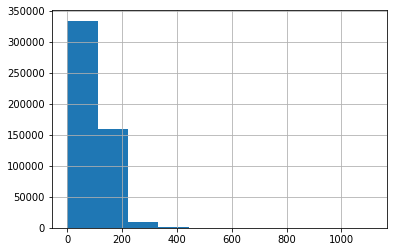

In [97]:
#print(f'min surface {data['Surface reelle bati'].min()} - max surface {data['Surface reelle bati'].max()}')
data['Surface reelle bati'].hist(range=(data['Surface reelle bati'].min(),data['Surface reelle bati'].max()))

In [ ]:
#drop surfaces between 20 and 300
data.drop(data[(data["Surface reelle bati"]> 300 ) | ( data["Surface reelle bati"] < 20 )].index, inplace=True)

### 2. Correlations between features and target

In [77]:

features = data.iloc[:,3:].columns.tolist()
target = data.iloc[:,2].name

correlations = {}
for f in features:
    data_temp = data[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]


In [78]:

data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]


,Value
Surface reelle bati vs Valeur fonciere,0.013535
Surface terrain vs Valeur fonciere,0.011165
Nombre pieces principales vs Valeur fonciere,0.009706
Code postal vs Valeur fonciere,-0.006016


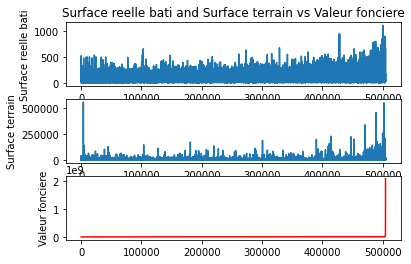

In [79]:

y = data.loc[:,['Surface reelle bati','Surface terrain', target]].sort_values(target, ascending=True).values
x = np.arange(y.shape[0])

plt.subplot(3,1,1)
plt.plot(x,y[:,0])
plt.title('Surface reelle bati and Surface terrain vs Valeur fonciere')
plt.ylabel('Surface reelle bati')

plt.subplot(3,1,2)
plt.plot(x,y[:,1])
plt.ylabel('Surface terrain')

plt.subplot(3,1,3)
plt.plot(x,y[:,2],'r')
plt.ylabel("Valeur fonciere")


plt.show()




In [80]:
regr = LinearRegression()
#filter by town
new_data = data[data['Code postal'] == 63000]
new_data = data[['Surface reelle bati','Nombre pieces principales','Surface terrain']]



In [81]:
X = new_data.values
y = data['Valeur fonciere'].values

In [82]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y ,test_size=0.33)

In [83]:
regr.fit(X_train, y_train)
print(regr.predict(X_test))

[261404.69038233 310808.13900486 274621.00776729 ... 262137.59919924
 181772.07198841 213671.90252918]


In [84]:
regr.score(X_test,y_test)

0.0003104351476275191

In [85]:
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((regr.predict(X_test) - y_test) ** 2)))

RMSE: 4781475.06


In [86]:
# Let's try XGboost algorithm to see if we can get better results
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [87]:
traindf, testdf = train_test_split(X_train, test_size = 0.3)
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.75,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [88]:
predictions = xgb.predict(X_test)
print(explained_variance_score(predictions,y_test))

-25.482312601538844
